In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


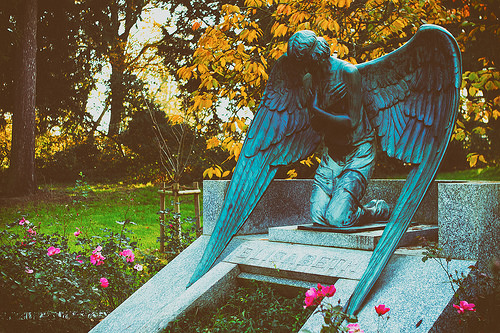

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

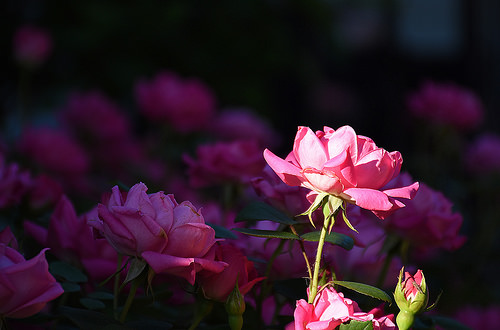

In [ ]:
PIL.Image.open(str(roses[1]))

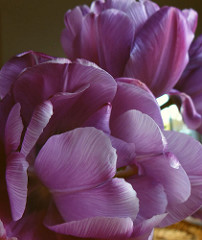

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

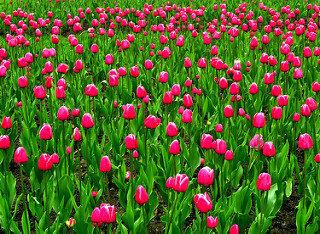

In [ ]:
PIL.Image.open(str(tulips[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

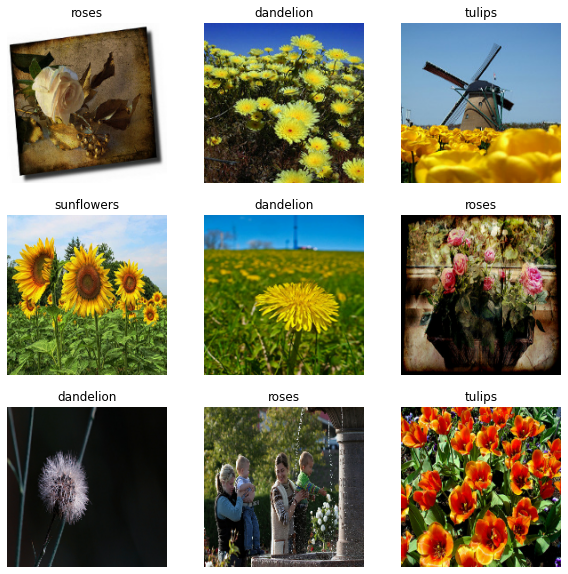

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

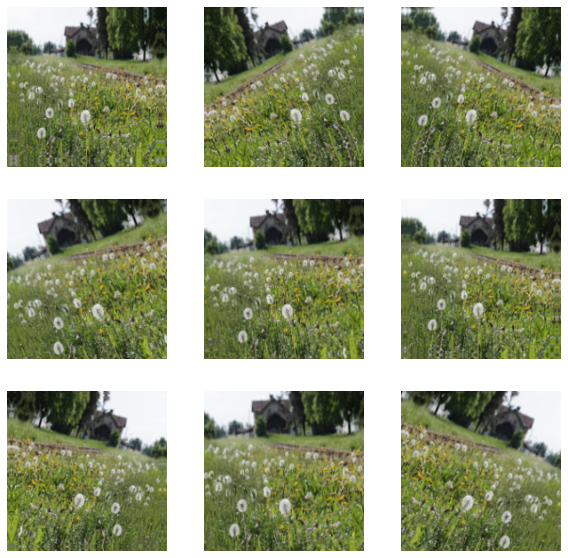

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Transfer Learning 

# VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
vg19 = VGG19(input_shape=(180,180,3), weights="imagenet", include_top=False)

80142336/80134624 [==============================] - 0s 0us/step


In [ ]:
for layer in vg19.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(vg19.output)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [ ]:
modelvg.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0   

In [ ]:
history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 27s 241ms/step - loss: 8.2213 - accuracy: 0.6040 - val_loss: 5.5473 - val_accuracy: 0.7575
Epoch 2/10
92/92 [==============================] - 14s 155ms/step - loss: 1.2489 - accuracy: 0.9002 - val_loss: 5.3306 - val_accuracy: 0.7589
Epoch 3/10
92/92 [==============================] - 14s 152ms/step - loss: 0.5367 - accuracy: 0.9481 - val_loss: 4.6497 - val_accuracy: 0.7929
Epoch 4/10
92/92 [==============================] - 14s 148ms/step - loss: 0.1821 - accuracy: 0.9764 - val_loss: 5.0409 - val_accuracy: 0.7807
Epoch 5/10
92/92 [==============================] - 14s 148ms/step - loss: 0.1146 - accuracy: 0.9826 - val_loss: 5.3112 - val_accuracy: 0.8011
Epoch 6/10
92/92 [==============================] - 14s 152ms/step - loss: 0.0517 - accuracy: 0.9892 - val_loss: 4.8444 - val_accuracy: 0.8093
Epoch 7/10
92/92 [==============================] - 14s 153ms/step - loss: 0.0653 - accuracy: 0.9913 - val_loss: 5.2855 - val_accuracy: 0.7984

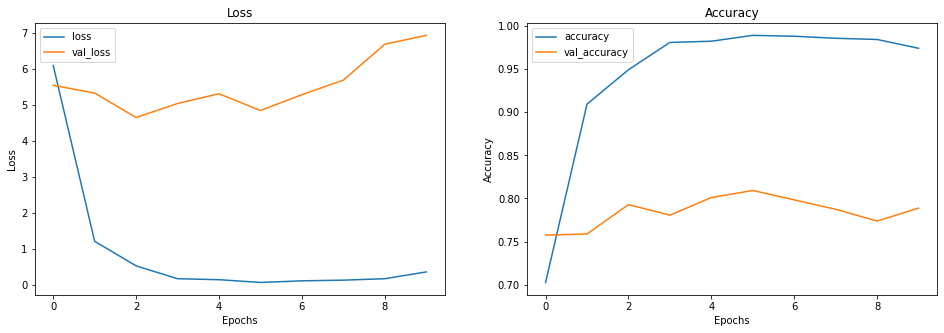

In [ ]:
plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

## Vgg19 2

Epoch 1/10
92/92 [==============================] - 15s 149ms/step - loss: 12.3181 - accuracy: 0.5721 - val_loss: 0.7289 - val_accuracy: 0.7520
Epoch 2/10
92/92 [==============================] - 14s 154ms/step - loss: 0.3646 - accuracy: 0.8682 - val_loss: 0.8495 - val_accuracy: 0.7738
Epoch 3/10
92/92 [==============================] - 14s 156ms/step - loss: 0.1407 - accuracy: 0.9492 - val_loss: 0.7609 - val_accuracy: 0.7902
Epoch 4/10
92/92 [==============================] - 14s 153ms/step - loss: 0.0787 - accuracy: 0.9767 - val_loss: 0.8337 - val_accuracy: 0.7997
Epoch 5/10
92/92 [==============================] - 14s 149ms/step - loss: 0.0235 - accuracy: 0.9945 - val_loss: 0.8973 - val_accuracy: 0.8079
Epoch 6/10
92/92 [==============================] - 14s 148ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.9451 - val_accuracy: 0.8052
Epoch 7/10
92/92 [==============================] - 14s 151ms/step - loss: 0.0236 - accuracy: 0.9964 - val_loss: 0.9400 - val_accuracy: 0.807

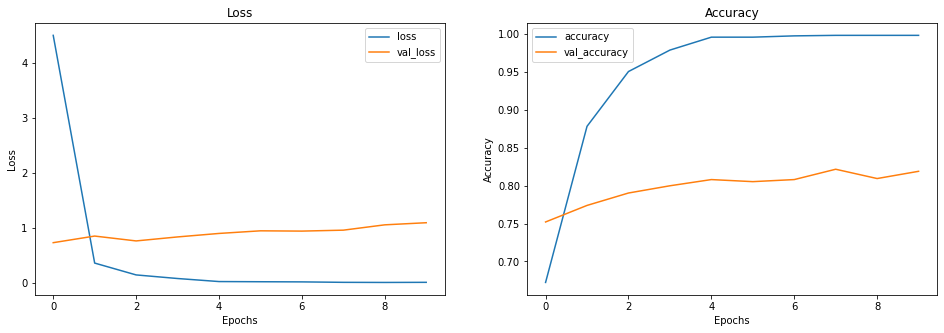

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dense(256, activation='relu')(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Epoch 1/10
92/92 [==============================] - 14s 149ms/step - loss: 7.4149 - accuracy: 0.5592 - val_loss: 0.8483 - val_accuracy: 0.6880
Epoch 2/10
92/92 [==============================] - 14s 153ms/step - loss: 0.7627 - accuracy: 0.7416 - val_loss: 0.8357 - val_accuracy: 0.7302
Epoch 3/10
92/92 [==============================] - 14s 156ms/step - loss: 0.4796 - accuracy: 0.8613 - val_loss: 0.7334 - val_accuracy: 0.7698
Epoch 4/10
92/92 [==============================] - 14s 153ms/step - loss: 0.3437 - accuracy: 0.8826 - val_loss: 0.7444 - val_accuracy: 0.7943
Epoch 5/10
92/92 [==============================] - 14s 149ms/step - loss: 0.2652 - accuracy: 0.9165 - val_loss: 0.7812 - val_accuracy: 0.7997
Epoch 6/10
92/92 [==============================] - 14s 147ms/step - loss: 0.1779 - accuracy: 0.9436 - val_loss: 0.7388 - val_accuracy: 0.7929
Epoch 7/10
92/92 [==============================] - 14s 150ms/step - loss: 0.1316 - accuracy: 0.9605 - val_loss: 0.8962 - val_accuracy: 0.8011

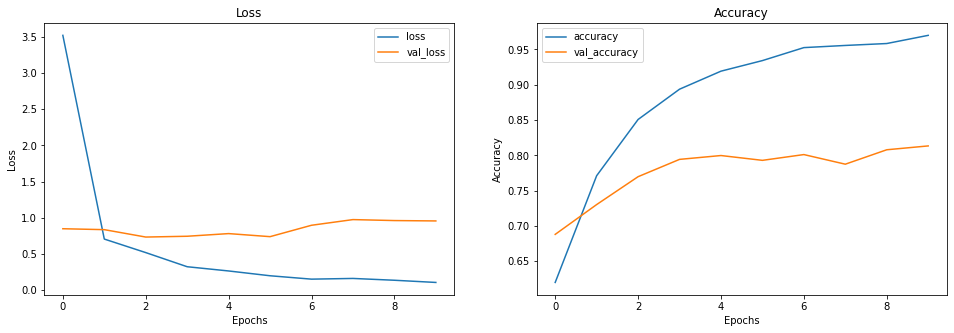

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 3

Epoch 1/10
92/92 [==============================] - 13s 135ms/step - loss: 9.5812 - accuracy: 0.4623 - val_loss: 0.9251 - val_accuracy: 0.6199
Epoch 2/10
92/92 [==============================] - 13s 137ms/step - loss: 1.1216 - accuracy: 0.6083 - val_loss: 0.8570 - val_accuracy: 0.7166
Epoch 3/10
92/92 [==============================] - 13s 139ms/step - loss: 1.0367 - accuracy: 0.6546 - val_loss: 0.7546 - val_accuracy: 0.7452
Epoch 4/10
92/92 [==============================] - 13s 141ms/step - loss: 0.9254 - accuracy: 0.7002 - val_loss: 0.7325 - val_accuracy: 0.7480
Epoch 5/10
92/92 [==============================] - 13s 145ms/step - loss: 0.8446 - accuracy: 0.7369 - val_loss: 0.7421 - val_accuracy: 0.7548
Epoch 6/10
92/92 [==============================] - 14s 149ms/step - loss: 0.7858 - accuracy: 0.7416 - val_loss: 0.6311 - val_accuracy: 0.7725
Epoch 7/10
92/92 [==============================] - 14s 152ms/step - loss: 0.6029 - accuracy: 0.7674 - val_loss: 0.6525 - val_accuracy: 0.7956

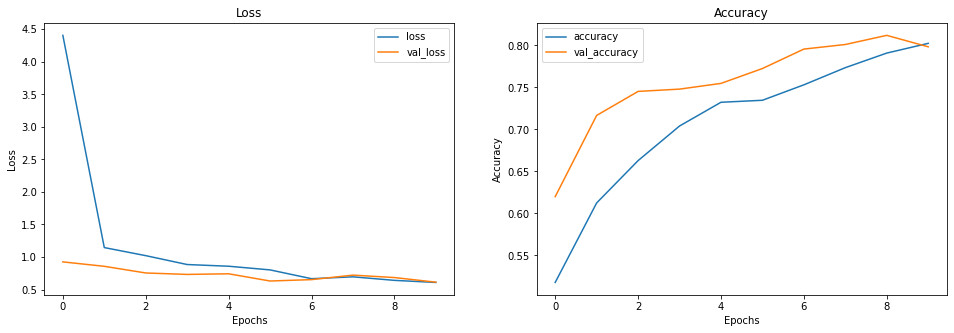

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 4

Epoch 1/10
92/92 [==============================] - 13s 131ms/step - loss: 8.4497 - accuracy: 0.5479 - val_loss: 0.8574 - val_accuracy: 0.6853
Epoch 2/10
92/92 [==============================] - 12s 134ms/step - loss: 0.8654 - accuracy: 0.7079 - val_loss: 0.8166 - val_accuracy: 0.7125
Epoch 3/10
92/92 [==============================] - 12s 135ms/step - loss: 0.6139 - accuracy: 0.7972 - val_loss: 0.7540 - val_accuracy: 0.7657
Epoch 4/10
92/92 [==============================] - 13s 138ms/step - loss: 0.4876 - accuracy: 0.8382 - val_loss: 0.7320 - val_accuracy: 0.7834
Epoch 5/10
92/92 [==============================] - 13s 140ms/step - loss: 0.4689 - accuracy: 0.8565 - val_loss: 0.7197 - val_accuracy: 0.7766
Epoch 6/10
92/92 [==============================] - 13s 141ms/step - loss: 0.3772 - accuracy: 0.8771 - val_loss: 0.7331 - val_accuracy: 0.7847
Epoch 7/10
92/92 [==============================] - 13s 144ms/step - loss: 0.3168 - accuracy: 0.8971 - val_loss: 0.8349 - val_accuracy: 0.7629

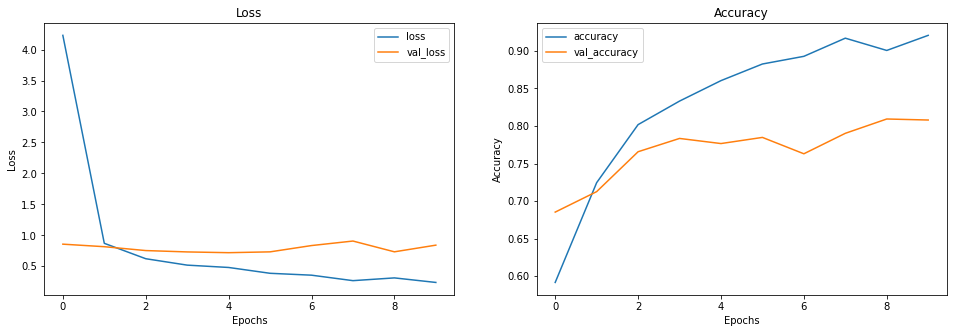

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 5

Epoch 1/10
92/92 [==============================] - 13s 136ms/step - loss: 6.6716 - accuracy: 0.4743 - val_loss: 0.9329 - val_accuracy: 0.6049
Epoch 2/10
92/92 [==============================] - 13s 138ms/step - loss: 0.9864 - accuracy: 0.6638 - val_loss: 0.7863 - val_accuracy: 0.7071
Epoch 3/10
92/92 [==============================] - 13s 140ms/step - loss: 0.7292 - accuracy: 0.7281 - val_loss: 0.6663 - val_accuracy: 0.7657
Epoch 4/10
92/92 [==============================] - 13s 144ms/step - loss: 0.6238 - accuracy: 0.7693 - val_loss: 0.6424 - val_accuracy: 0.7820
Epoch 5/10
92/92 [==============================] - 14s 148ms/step - loss: 0.5841 - accuracy: 0.7928 - val_loss: 0.6379 - val_accuracy: 0.7847
Epoch 6/10
92/92 [==============================] - 14s 150ms/step - loss: 0.5140 - accuracy: 0.8033 - val_loss: 0.6598 - val_accuracy: 0.7916
Epoch 7/10
92/92 [==============================] - 14s 152ms/step - loss: 0.4481 - accuracy: 0.8297 - val_loss: 0.6444 - val_accuracy: 0.7984

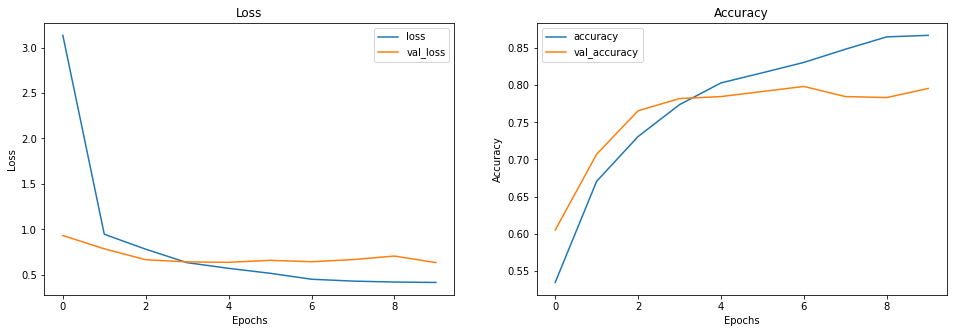

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 6

Epoch 1/10
92/92 [==============================] - 14s 150ms/step - loss: 5.0200 - accuracy: 0.3609 - val_loss: 1.2170 - val_accuracy: 0.4864
Epoch 2/10
92/92 [==============================] - 14s 153ms/step - loss: 1.4205 - accuracy: 0.4594 - val_loss: 1.0873 - val_accuracy: 0.5504
Epoch 3/10
92/92 [==============================] - 14s 152ms/step - loss: 1.2063 - accuracy: 0.5528 - val_loss: 1.0344 - val_accuracy: 0.5436
Epoch 4/10
92/92 [==============================] - 14s 152ms/step - loss: 1.1028 - accuracy: 0.6002 - val_loss: 0.8273 - val_accuracy: 0.6431
Epoch 5/10
92/92 [==============================] - 14s 151ms/step - loss: 1.0343 - accuracy: 0.6121 - val_loss: 0.9202 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 14s 151ms/step - loss: 0.9720 - accuracy: 0.6433 - val_loss: 0.8760 - val_accuracy: 0.6485
Epoch 7/10
92/92 [==============================] - 14s 152ms/step - loss: 0.8555 - accuracy: 0.6943 - val_loss: 0.8135 - val_accuracy: 0.7125

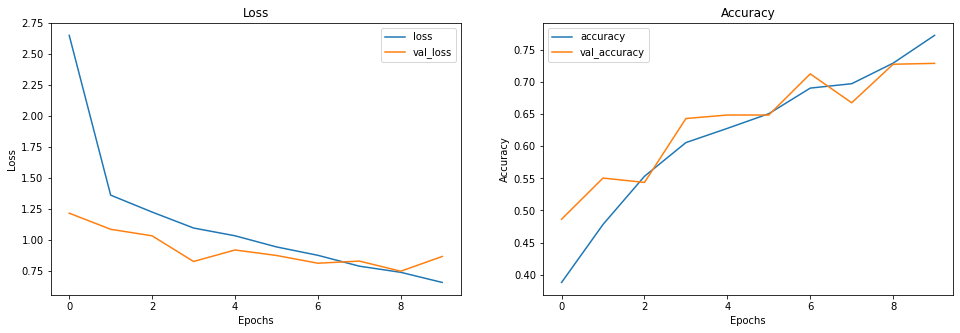

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 7

Epoch 1/10
92/92 [==============================] - 14s 151ms/step - loss: 4.5010 - accuracy: 0.4300 - val_loss: 0.9128 - val_accuracy: 0.6608
Epoch 2/10
92/92 [==============================] - 14s 155ms/step - loss: 1.0030 - accuracy: 0.6103 - val_loss: 0.8065 - val_accuracy: 0.6894
Epoch 3/10
92/92 [==============================] - 14s 155ms/step - loss: 0.8803 - accuracy: 0.6808 - val_loss: 0.7861 - val_accuracy: 0.6975
Epoch 4/10
92/92 [==============================] - 14s 152ms/step - loss: 0.8213 - accuracy: 0.7122 - val_loss: 0.6994 - val_accuracy: 0.7343
Epoch 5/10
92/92 [==============================] - 14s 149ms/step - loss: 0.7237 - accuracy: 0.7381 - val_loss: 0.7350 - val_accuracy: 0.7425
Epoch 6/10
92/92 [==============================] - 14s 149ms/step - loss: 0.6286 - accuracy: 0.7756 - val_loss: 0.7073 - val_accuracy: 0.7698
Epoch 7/10
92/92 [==============================] - 14s 152ms/step - loss: 0.6120 - accuracy: 0.7847 - val_loss: 0.6937 - val_accuracy: 0.7643

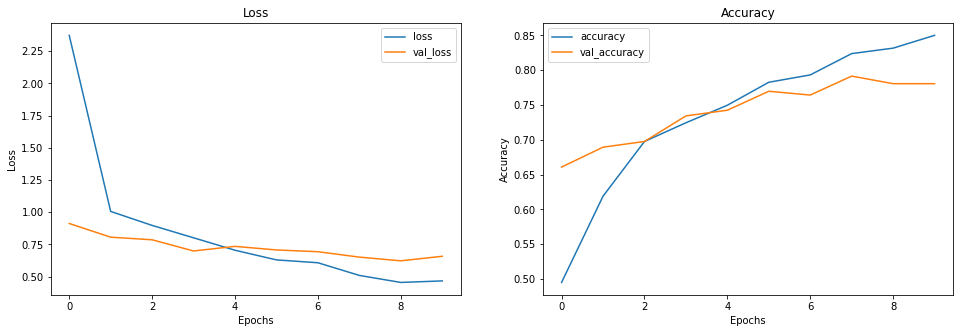

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 8

Epoch 1/10
92/92 [==============================] - 13s 139ms/step - loss: 7.7804 - accuracy: 0.3303 - val_loss: 1.2014 - val_accuracy: 0.5163
Epoch 2/10
92/92 [==============================] - 13s 139ms/step - loss: 1.3824 - accuracy: 0.4712 - val_loss: 0.9671 - val_accuracy: 0.6431
Epoch 3/10
92/92 [==============================] - 13s 141ms/step - loss: 1.2147 - accuracy: 0.5363 - val_loss: 0.9398 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 13s 144ms/step - loss: 1.0852 - accuracy: 0.5949 - val_loss: 0.8577 - val_accuracy: 0.6880
Epoch 5/10
92/92 [==============================] - 14s 147ms/step - loss: 1.0630 - accuracy: 0.5912 - val_loss: 0.7899 - val_accuracy: 0.7316
Epoch 6/10
92/92 [==============================] - 14s 152ms/step - loss: 1.0682 - accuracy: 0.6268 - val_loss: 0.7653 - val_accuracy: 0.7343
Epoch 7/10
92/92 [==============================] - 14s 153ms/step - loss: 0.9147 - accuracy: 0.6435 - val_loss: 0.7419 - val_accuracy: 0.7411

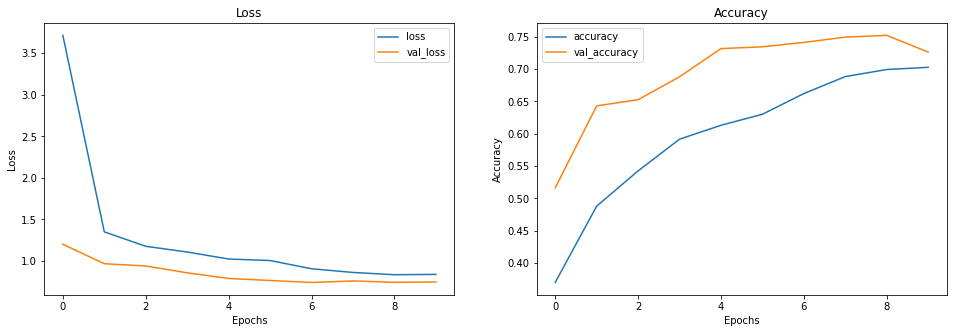

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 9

Epoch 1/10
92/92 [==============================] - 14s 151ms/step - loss: 4.5647 - accuracy: 0.3021 - val_loss: 1.2474 - val_accuracy: 0.4837
Epoch 2/10
92/92 [==============================] - 14s 154ms/step - loss: 1.5561 - accuracy: 0.3810 - val_loss: 1.1358 - val_accuracy: 0.4823
Epoch 3/10
92/92 [==============================] - 14s 155ms/step - loss: 1.5435 - accuracy: 0.3806 - val_loss: 1.0952 - val_accuracy: 0.4986
Epoch 4/10
92/92 [==============================] - 14s 152ms/step - loss: 1.3757 - accuracy: 0.4048 - val_loss: 1.1192 - val_accuracy: 0.4891
Epoch 5/10
92/92 [==============================] - 14s 149ms/step - loss: 1.4212 - accuracy: 0.4553 - val_loss: 1.0433 - val_accuracy: 0.5545
Epoch 6/10
92/92 [==============================] - 14s 149ms/step - loss: 1.3159 - accuracy: 0.4638 - val_loss: 1.1222 - val_accuracy: 0.5490
Epoch 7/10
92/92 [==============================] - 14s 152ms/step - loss: 1.2256 - accuracy: 0.4747 - val_loss: 1.0513 - val_accuracy: 0.5981

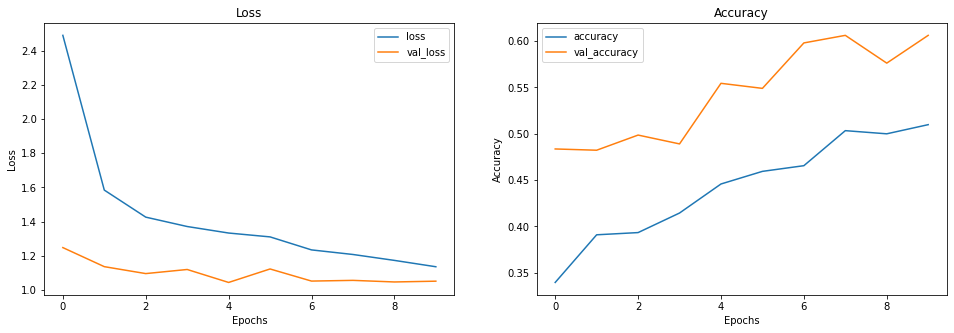

In [ ]:
x = layers.Flatten()(vg19.output)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Vgg19 10

Epoch 1/10
92/92 [==============================] - 14s 150ms/step - loss: 9.0348 - accuracy: 0.4219 - val_loss: 0.9769 - val_accuracy: 0.6308
Epoch 2/10
92/92 [==============================] - 14s 154ms/step - loss: 1.3253 - accuracy: 0.5669 - val_loss: 0.8676 - val_accuracy: 0.7016
Epoch 3/10
92/92 [==============================] - 14s 156ms/step - loss: 1.2474 - accuracy: 0.6210 - val_loss: 0.9198 - val_accuracy: 0.6921
Epoch 4/10
92/92 [==============================] - 14s 153ms/step - loss: 1.0700 - accuracy: 0.6886 - val_loss: 0.7607 - val_accuracy: 0.7262
Epoch 5/10
92/92 [==============================] - 14s 149ms/step - loss: 0.9207 - accuracy: 0.7061 - val_loss: 0.7944 - val_accuracy: 0.7248
Epoch 6/10
92/92 [==============================] - 14s 148ms/step - loss: 0.8514 - accuracy: 0.7090 - val_loss: 0.7290 - val_accuracy: 0.7507
Epoch 7/10
92/92 [==============================] - 14s 151ms/step - loss: 0.7584 - accuracy: 0.7509 - val_loss: 0.7672 - val_accuracy: 0.7384

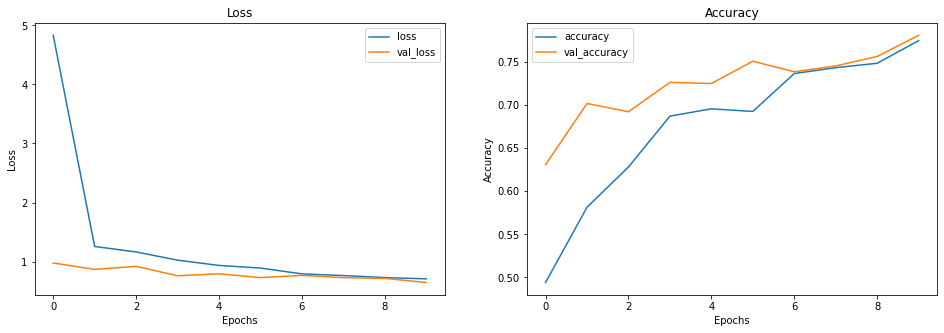

In [ ]:
x = layers.Flatten()(vg19.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
prediction = layers.Dense(5, activation="softmax")(x)
modelvg = keras.Model(inputs=vg19.input, outputs=prediction)
modelvg.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

history = modelvg.fit(train_ds, validation_data=val_ds, epochs=10)

plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(180,180,3)))

for layer in basemodel.layers[:]:
  layers.trainable = False

input = basemodel.output
model = layers.MaxPooling2D(pool_size=(2,2))(input)
model = layers.Flatten(name='flatten')(model)
model = layers.Dense(256, activation='relu')(model)
# model = layers.Dropout(0.5)(model)
model = layers.Dense(128, activation='relu')(model)
# model = layers.Dropout(0.5)(model)
model = layers.Dense(64, activation='relu')(model)
model = layers.Dense(5, activation='softmax')(model)

model = keras.models.Model(inputs=basemodel.input, outputs=model)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
92/92 [==============================] - 29s 267ms/step - loss: 3.1791 - accuracy: 0.4844 - val_loss: 3.2358 - val_accuracy: 0.2807
Epoch 2/15
92/92 [==============================] - 24s 259ms/step - loss: 0.6163 - accuracy: 0.7804 - val_loss: 31.6305 - val_accuracy: 0.3215
Epoch 3/15
92/92 [==============================] - 24s 264ms/step - loss: 0.5333 - accuracy: 0.8130 - val_loss: 15.7074 - val_accuracy: 0.3801
Epoch 4/15
92/92 [==============================] - 24s 265ms/step - loss: 0.3712 - accuracy: 0.8774 - val_loss: 1.6910 - val_accuracy: 0.6580
Epoch 5/15
92/92 [==============================] - 24s 263ms/step - loss: 0.2800 - accuracy: 0.9001 - val_loss: 2.6060 - val_accuracy: 0.4196
Epoch 6/15
92/92 [==============================] - 24s 264ms/step - loss: 0.3253 - accuracy: 0.8932 - val_loss: 807.8275 - val_accuracy: 0.1798
Epoch 7/15
92/92 [==============================] - 24s 264ms/step - loss: 0.3503 - accuracy: 0.8913 - val_loss: 2.8087 - val_accuracy: 0.

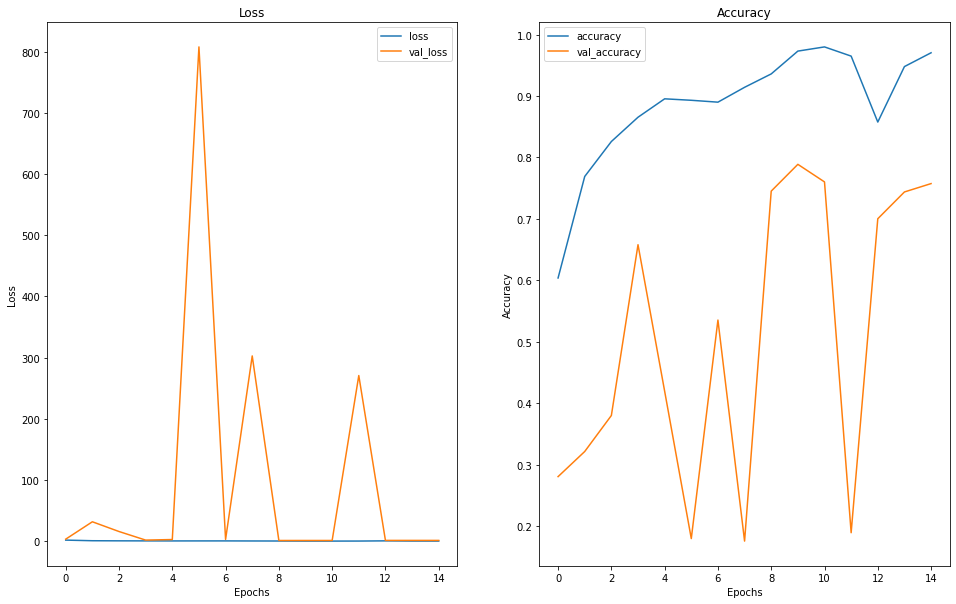

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(131)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(132)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()